# Курсовая работа "Активное обучение"


Выполнили:
* Моисеенков Илья
* Шавандрин Федор
* Пестерников Данил
* Гаптулхаков Руслан
* Терешков Алексей

М8О-214М-23

In [97]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import tqdm
import tqdm.notebook
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. Подготовка

### 1.1 Выбор датасета
В качестве датасета был выбран CIFAR-10

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [4]:
df = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=transform)

Files already downloaded and verified


In [5]:
df

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
df_test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=transform)

Files already downloaded and verified


In [7]:
df_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
train_loader = DataLoader(df, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(df_test, batch_size=128, shuffle=False, num_workers=2)

### 1.2 Выбор базовой модели

Будем использовать EfficientNet-b0

In [9]:
def init_model():
    model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    model.classifier = nn.Linear(model.classifier[1].in_features, 10)
    model = model.to(device)
    return model

### 1.3 Пайплайн обучения

In [68]:
def train_model(model, train_loader, epochs=10, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model.train()

    for epoch in tqdm.notebook.tqdm(range(epochs)):
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if verbose:
            print(f'epoch: {epoch + 1}, loss: {running_loss / len(train_loader):.3f}')

    return model

In [69]:
def test_model(model, test_loader):
    model.eval()
    preds_full = []
    labels_full = []

    with torch.no_grad():
        for images, labels in tqdm.notebook.tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)

            preds_full.extend(preds.cpu().numpy())
            labels_full.extend(labels.cpu().numpy())

    return f1_score(preds_full, labels_full, average='weighted')


### 1.4 Обучение базовой модели

Попробуем обучить модель на всем наборе данных, чтобы получить верхнюю грань потенциального качества

In [12]:
model_full = init_model()
model_full = train_model(model_full, train_loader, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 1.003
epoch: 2, loss: 0.589
epoch: 3, loss: 0.455
epoch: 4, loss: 0.367
epoch: 5, loss: 0.305
epoch: 6, loss: 0.266
epoch: 7, loss: 0.230
epoch: 8, loss: 0.206
epoch: 9, loss: 0.173
epoch: 10, loss: 0.149


In [13]:
model_full_score = test_model(model_full, test_loader)
model_full_score

  0%|          | 0/79 [00:00<?, ?it/s]

0.8340364782808736

Скор базовой модели без активного обучения = **0.834**

### 1.5 Обучение модели на подвыборке

Создание подвыборки

In [14]:
def create_truncated_df(df, fraction):
    indices = random.sample(range(len(df)), int(fraction * len(df)))
    return Subset(df, indices)

In [15]:
df_001 = create_truncated_df(df, 0.01)
df_01 = create_truncated_df(df, 0.1)
df_02 = create_truncated_df(df, 0.2)

In [16]:
len(df), len(df_001), len(df_01), len(df_02)

(50000, 500, 5000, 10000)

In [17]:
train_loader_001 = DataLoader(df_001, batch_size=128, shuffle=True, num_workers=2)
train_loader_01 = DataLoader(df_01, batch_size=128, shuffle=True, num_workers=2)
train_loader_02 = DataLoader(df_02, batch_size=128, shuffle=True, num_workers=2)

Обучим модели на подвыборках размером 1/10/20 процентов от исходного датасета.

Валидироать каждую модель будем на **всем тестовом датасете** (поэтому не обязательно прогонять модель 5 раз)

Здесь мы по сути хотим получить нижнюю грань потенциального качества, ведь мы обучаемся на небольшом наборе данных и никак не используем остальную часть

Модель на 1% данных без активного обучения

In [18]:
model_001 = init_model()
model_001 = train_model(model_001, train_loader_001, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 2.313
epoch: 2, loss: 1.705
epoch: 3, loss: 1.201
epoch: 4, loss: 0.802
epoch: 5, loss: 0.480
epoch: 6, loss: 0.283
epoch: 7, loss: 0.175
epoch: 8, loss: 0.111
epoch: 9, loss: 0.074
epoch: 10, loss: 0.050


In [19]:
model_001_score = test_model(model_001, test_loader)
model_001_score

  0%|          | 0/79 [00:00<?, ?it/s]

0.45476602084151346

Скор модели на 1% без активного обучения = **0.455**

Модель на 10% данных без активного обучения

In [20]:
model_01 = init_model()
model_01 = train_model(model_01, train_loader_01, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 1.821
epoch: 2, loss: 1.145
epoch: 3, loss: 0.851
epoch: 4, loss: 0.720
epoch: 5, loss: 0.629
epoch: 6, loss: 0.501
epoch: 7, loss: 0.434
epoch: 8, loss: 0.374
epoch: 9, loss: 0.255
epoch: 10, loss: 0.247


In [21]:
model_01_score = test_model(model_01, test_loader)
model_01_score

  0%|          | 0/79 [00:00<?, ?it/s]

0.6661026666322225

Скор модели на 10% без активного обучения = **0.666**

Модель на 20% данных без активного обучения

In [22]:
model_02 = init_model()
model_02 = train_model(model_02, train_loader_02, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 1.523
epoch: 2, loss: 0.922
epoch: 3, loss: 0.641
epoch: 4, loss: 0.504
epoch: 5, loss: 0.415
epoch: 6, loss: 0.337
epoch: 7, loss: 0.276
epoch: 8, loss: 0.226
epoch: 9, loss: 0.192
epoch: 10, loss: 0.186


In [23]:
model_02_score = test_model(model_02, test_loader)
model_02_score

  0%|          | 0/79 [00:00<?, ?it/s]

0.7426222923309888

Скор модели на 20% без активного обучения = **0.743**

# 2. Активное обучение

### 2.1 Пайплайн для активного обучения

 Инициализация данных для активного обучения - берем рандомные fraction процентов данных. Будем считать их размеченными, а остальные - пока что не размеченными

In [70]:
def init_labelling(dataset, fraction):
    random.seed(0xDEAD)
    labeled_size = int(len(dataset) * fraction)
    labeled_ids = random.sample(range(len(dataset)), labeled_size)
    unlabeled_ids = list(set(range(len(dataset))) - set(labeled_ids))

    return labeled_ids, unlabeled_ids

Пайплайн для обучения.

Верхнеуровнево он устроен так:
1. Обучаем базовую модель на небольшом наборе размеченных данных
2. Применяем один из алгоритмов активного обучения, чтоы получить новые данные, которые нужно добавить в обучающую выборку. Добавлять будем по 1 проценту от общего объема данных
3. Достаем разметку для выбранных алгоритмом данных. Дообучаем модель на обновленном наборе
4. Повторяем цикл активного обучения несколько раз (например 5)

In [101]:
def active_learning_pipeline(dataset, fraction, test_loader, al_method, al_iters_cnt=5):
    labeled_ids, unlabeled_ids = init_labelling(dataset, fraction)
    labeled_df = Subset(dataset, labeled_ids)
    unlabeled_df = Subset(dataset, unlabeled_ids)
    labeled_loader = DataLoader(labeled_df, batch_size=128, shuffle=True, num_workers=2)
    unlabeled_loader = DataLoader(unlabeled_df, batch_size=128, shuffle=True, num_workers=2)

    # train on labeled data
    model = init_model()
    model = train_model(model, labeled_loader, epochs=5, verbose=False)

    for i in range(al_iters_cnt):
        print(f'Active learning: iter {i + 1}')
        # get new data with active learning algorithm
        al_indices = al_method(model, unlabeled_loader, int(len(dataset) * 0.01))
        al_data_indices = [unlabeled_ids[i] for i in al_indices]

        # add new data to training dataset
        labeled_ids.extend(al_data_indices)
        unlabeled_ids = list(set(unlabeled_ids) - set(al_data_indices))
        labeled_df = Subset(dataset, labeled_ids)
        labeled_loader = DataLoader(labeled_df, batch_size=128, shuffle=True)
        unlabeled_df = Subset(dataset, unlabeled_ids)
        unlabeled_loader = DataLoader(unlabeled_df, batch_size=128, shuffle=True)

        # update model
        model = train_model(model, labeled_loader, epochs=5, verbose=False)

    score = test_model(model, test_loader)
    model = model.cpu()
    return model, score


### 2.2 Методы для активного обучения

#### Алгоритм Least Confidence (LC)

*Алгоритм Least Confidence (LC)* - это метод активного обучения, который выбирает сэмплы для разметки данных на основе уверенности модели в своих предсказаниях. Предположим, у нас есть обученная модель, и мы хотим выбрать несколько сэмплов из неразмеченного набора данных для разметки. Мы будем использовать модель для предсказания вероятностей классов и выбирать те сэмплы, для которых модель имеет наименьшую уверенность.

In [76]:
def least_confidence_selection(model, unlabeled_data, n_samples):
    """
    Выбирает n_samples из unlabeled_data на основе алгоритма Least Confidence.

    :param model: Обученная модель PyTorch
    :param unlabeled_data: Набор данных без меток (например, DataLoader)
    :param n_samples: Количество образцов для выбора
    :return: Индексы выбранных образцов
    """
    model.eval()
    confidences = []
    with torch.no_grad():
        for inputs, _ in unlabeled_data:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            least_confidence = 1 - torch.max(probabilities, dim=1)[0]
            confidences.append(least_confidence)
    confidences = torch.cat(confidences)
    selected_indices = torch.argsort(confidences)[:n_samples]
    return selected_indices.tolist()

#### Алгоритм Coreset

*Алгоритм Coreset (или "координационный набор")* — это метод активного обучения, который выбирает подмножество данных, представляющее весь набор данных, чтобы минимизировать ошибку модели.

In [77]:
def coreset_selection(model, unlabeled_data, n_samples):
    """
    Выбирает n_samples из unlabeled_data на основе алгоритма Coreset.

    :param model: Обученная модель PyTorch
    :param unlabeled_data: Набор данных без меток (например, DataLoader)
    :param n_samples: Количество образцов для выбора
    :return: Индексы выбранных образцов
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, _ in unlabeled_data:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            embeddings.append(outputs)
            labels.append(probabilities)
    embeddings = torch.cat(embeddings).cpu()
    selected_indices = []
    for _ in range(n_samples):
        if len(selected_indices) == 0:
            idx = np.random.choice(len(embeddings))
        else:
            remaining_indices = list(set(range(len(embeddings))) - set(selected_indices))
            remaining_embeddings = embeddings[remaining_indices]
            selected_embeddings = embeddings[selected_indices]
            distances_to_selected = torch.cdist(remaining_embeddings, selected_embeddings).min(dim=1)[0]
            idx = remaining_indices[distances_to_selected.argmax()]
        selected_indices.append(idx)
    return selected_indices

#### Алгоритм Maximum Normalized Log-Probability (MNLP)

*Алгоритм Maximum Normalized Log-Probability (MNLP)* — это метод активного обучения, который выбирает образцы для аннотирования на основе нормализованной логарифмической вероятности предсказаний модели.

In [78]:
def mnlp_selection(model, unlabeled_data, n_samples):
    """
    Выбирает n_samples из unlabeled_data на основе алгоритма Maximum Normalized Log-Probability (MNLP).

    :param model: Обученная модель PyTorch
    :param unlabeled_data: Набор данных без меток (например, DataLoader)
    :param n_samples: Количество образцов для выбора
    :return: Индексы выбранных образцов
    """
    model.eval()
    log_probabilities = []
    with torch.no_grad():
        for inputs, _ in unlabeled_data:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            log_probs = torch.log(probabilities + 1e-10)
            log_probabilities.append(log_probs)

    log_probabilities = torch.cat(log_probabilities)
    normalized_log_probs = log_probabilities - log_probabilities.max(dim=1, keepdim=True)[0]
    max_normalized_log_probs = normalized_log_probs.max(dim=1)[0]
    selected_indices = torch.argsort(max_normalized_log_probs, descending=True)[:n_samples]
    return selected_indices.tolist()

#### Алгоритм BADGE (Batch Active learning by Diverse Gradient Embedding)

*Алгоритм BADGE* — это метод активного обучения, который использует градиентные эмбеддинги для выбора наиболее информативных и разнообразных сэмплов. Он сочетает в себе учет неопределенности модели и разнообразие данных, выбирая точки, которые максимально улучшают обучение.

In [79]:
def badge_selection(model, unlabeled_loader, select_size):
    model.eval()
    gradient_embeddings = []
    indices = []

    for batch_idx, (images, labels) in enumerate(unlabeled_loader):
        images = images.to(next(model.parameters()).device)
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels.to(images.device))
        model.zero_grad()
        loss.backward()

        gradients = []
        for name, param in model.named_parameters():
            if param.requires_grad and 'classifier' in name:
                if param.grad is not None:
                    gradients.append(param.grad.flatten())
                else:
                    print(f"No gradient for parameter: {name}")

        if gradients:
            gradient_vector = torch.cat(gradients, dim=0).cpu().numpy()
            gradient_embeddings.append(gradient_vector)

            indices.extend(
                range(batch_idx * unlabeled_loader.batch_size,
                      batch_idx * unlabeled_loader.batch_size + len(images))
            )

    gradient_embeddings = np.array(gradient_embeddings)

    n_samples = gradient_embeddings.shape[0]
    select_size = min(select_size, n_samples)

    # Проводим кластеризацию KMeans с количеством кластеров, равным select_size
    kmeans = KMeans(n_clusters=select_size, random_state=42)
    kmeans.fit(gradient_embeddings)

    # Для каждого объекта выбираем ближайший к центроиду кластер
    distances = kmeans.transform(gradient_embeddings)
    selected_indices = np.argmin(distances, axis=0)

    return [indices[i] for i in selected_indices]

#### Алгоритм BAIT (Batch Active learning via Information maTrice)

*Алгоритм BAIT* — это метод активного обучения, который выбирает сэмплы на основе их информативности, оценивая их вклад в обогащение распределения данных.

In [80]:
def bait_selection(model, unlabeled_data, n_samples):
    """
    Выбирает n_samples из unlabeled_data на основе алгоритма BAIT.

    :param model: Обученная модель PyTorch
    :param unlabeled_data: Набор данных без меток (например, DataLoader)
    :param n_samples: Количество образцов для выбора
    :return: Индексы выбранных образцов
    """
    model.eval()
    embeddings = []
    with torch.no_grad():
        for inputs, _ in unlabeled_data:
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.append(outputs)

    embeddings = torch.cat(embeddings)

    # Вычисление информационного критерия (например, расстояния)
    pairwise_distances = torch.cdist(embeddings, embeddings, p=2)  # Матрица попарных расстояний
    information_scores = pairwise_distances.sum(dim=1)  # Информация для каждого сэмпла

    selected_indices = torch.argsort(information_scores, descending=True)[:n_samples]
    return selected_indices.tolist()

#### Алгоритм BALD (Bayesian Active Learning by Disagreement)

*Алгоритм BALD* — это метод активного обучения, который выбирает сэмплы, максимизирующие апостериорную энтропию модели. Он фокусируется на тех данных, по которым модель наиболее неуверенна. Для этого применяется техника MC Dropout, позволяющая получить несколько вероятностных предсказаний для одного сэмпла.

In [81]:
def bald_selection(model, unlabeled_data, n_samples, mc_samples=10):
    """
    Выбирает n_samples из unlabeled_data на основе алгоритма BAIT (Bayesian Active Learning by Disagreement).

    :param model: PyTorch модель с включенным Dropout
    :param unlabeled_data: Набор данных без меток (например, DataLoader)
    :param n_samples: Количество образцов для выбора
    :param mc_samples: Количество предсказаний для каждого входа (Monte Carlo выборки)
    :return: Индексы выбранных образцов
    """
    model.eval()
    disagreements = []
    with torch.no_grad():
        for inputs, _ in unlabeled_data:
            inputs = inputs.to(device)
            # Monte Carlo Dropout: несколько прогонов модели
            predictions = []
            for _ in range(mc_samples):
                outputs = model(inputs)
                probabilities = F.softmax(outputs, dim=1)
                predictions.append(probabilities.unsqueeze(0))

            predictions = torch.cat(predictions, dim=0)
            # Оцениваем несогласие: вариативность между предсказаниями
            variance = predictions.var(dim=0).mean(dim=1)
            disagreements.append(variance)

    disagreements = torch.cat(disagreements).cpu()
    selected_indices = torch.argsort(disagreements, descending=True)[:n_samples]

    return selected_indices.tolist()

### 2.3 Активное обучение моделей

In [110]:
torch.cuda.empty_cache()

In [115]:
al_methods = [
    # least_confidence_selection,
    # coreset_selection,
    # mnlp_selection,
    badge_selection,
    # bait_selection,
    # bald_selection,
]

In [108]:
fractions = [0.01, 0.1, 0.2]

In [60]:
models = dict()  # models[method][fraction] = model
for method in al_methods:
    models[method.__name__] = {}
models['full_data'] = {}
models['no_active_learn'] = {}

In [61]:
scores = dict()  # scores[method][fraction] = score
for method in al_methods:
    scores[method.__name__] = {}
scores['full_data'] = {}
scores['no_active_learn'] = {}

In [62]:
"""
models['full_data']['0.01'] = model_full
models['full_data']['0.1'] = model_full
models['full_data']['0.2'] = model_full

models['no_active_learn']['0.01'] = model_001
models['no_active_learn']['0.1'] = model_01
models['no_active_learn']['0.2'] = model_02
"""

"\nmodels['full_data']['0.01'] = model_full\nmodels['full_data']['0.1'] = model_full\nmodels['full_data']['0.2'] = model_full\n\nmodels['no_active_learn']['0.01'] = model_001\nmodels['no_active_learn']['0.1'] = model_01\nmodels['no_active_learn']['0.2'] = model_02\n"

In [63]:

scores['full_data']['0.01'] = model_full_score
scores['full_data']['0.1'] = model_full_score
scores['full_data']['0.2'] = model_full_score

scores['no_active_learn']['0.01'] = model_001_score
scores['no_active_learn']['0.1'] = model_01_score
scores['no_active_learn']['0.2'] = model_02_score


In [112]:
for fraction in fractions:
    for method in al_methods:
        print(f'Method: {method.__name__}, fraction: {fraction}')
        model, score = active_learning_pipeline(
            dataset=df,
            fraction=fraction,
            test_loader=test_loader,
            al_method=method,
            al_iters_cnt=5,
        )

        # models[method.__name__][str(fraction)] = model.cpu()
        scores[method.__name__][str(fraction)] = score

Method: bald_selection, fraction: 0.01


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 1


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 2


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 3


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 4


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Method: bald_selection, fraction: 0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 1


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 2


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 3


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 4


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Method: bald_selection, fraction: 0.2


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 1


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 2


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 3


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 4


  0%|          | 0/5 [00:00<?, ?it/s]

Active learning: iter 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [113]:
scores

{'least_confidence_selection': {'0.01': 0.6440742705395794,
  '0.1': 0.7389399814597583,
  '0.2': 0.756654187759632},
 'coreset_selection': {'0.01': 0.6546340578721634,
  '0.1': 0.7379698825730011,
  '0.2': 0.7762892256435964},
 'mnlp_selection': {'0.01': 0.6472021588911697,
  '0.1': 0.7417359300366337,
  '0.2': 0.7630071033867079},
 'full_data': {'0.01': 0.8340364782808736,
  '0.1': 0.8340364782808736,
  '0.2': 0.8340364782808736},
 'no_active_learn': {'0.01': 0.45476602084151346,
  '0.1': 0.6661026666322225,
  '0.2': 0.7426222923309888},
 'badge_selection': {},
 'bait_selection': {},
 'bald_selection': {'0.01': 0.6514067486947884,
  '0.1': 0.7303830895814917,
  '0.2': 0.7708031130858577}}

# 3. Сравнение результатов

Будем сравнивать все модели по скору F1

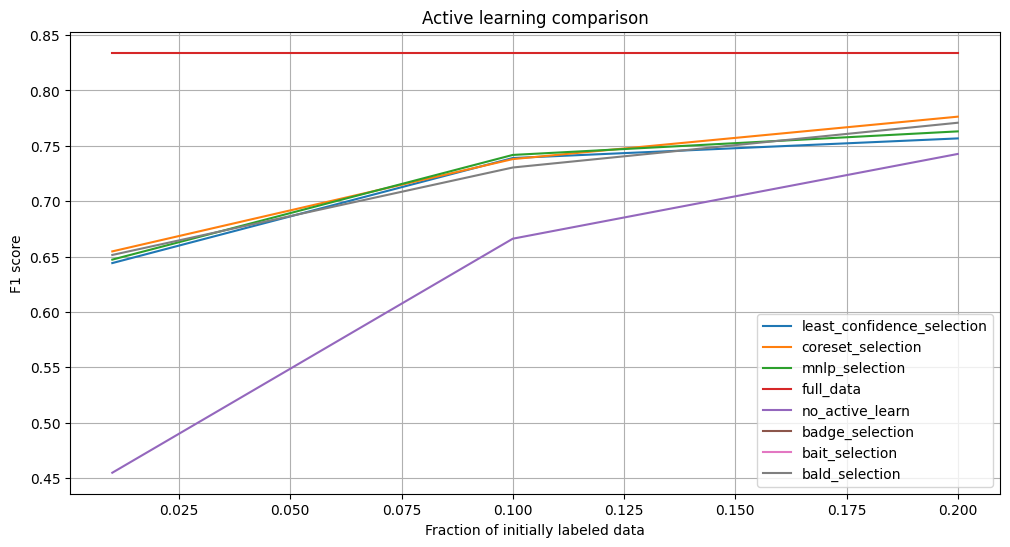

In [114]:
plt.figure(figsize=(12, 6))

for method, data in scores.items():
    x = []
    y = []
    for fraction, score in data.items():
        x.append(float(fraction))
        y.append(score)
    plt.plot(x, y, label=method)

plt.legend()
plt.xlabel('Fraction of initially labeled data')
plt.ylabel('F1 score')
plt.title('Active learning comparison')
plt.grid()
plt.show()